# Using Optimization and Machine Learning with `expsolve`

In [57]:
import time
import numpy as np
import matplotlib.pylab as plt

import expsolve as es
import expsolve.splittings.classical as split
import expsolve.fourier as ex

import torch
from torch import exp, sin, abs, real, imag, pi, diag
from torch.linalg import matrix_exp
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython import display
from torch.optim.lr_scheduler import StepLR

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Hamiltonian Identification

### True Hamiltonian

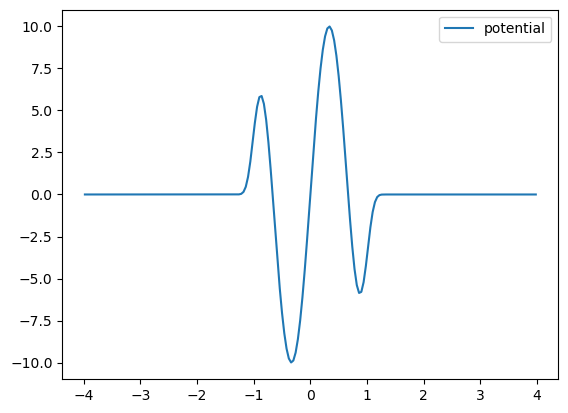

In [11]:
n = 200
L = 4
xr = [-L, L]
x = ex.grid1d(n, xr).to(device)                     # plot versions
V = 10.*exp(-x**8/1)*sin(1.5*pi*x)                  # plot versions

ex.plot(plt, x, V)

plt.legend(['potential'])
plt.show()

### Solvers

In [13]:
eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda V: lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

strangalpha, strangbeta = split.symmetric([],[])
strangstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, strangalpha, strangbeta)

a = torch.tensor([0.0792036964311957, 0.353172906049774, -0.0420650803577195], dtype=torch.float64)
b = torch.tensor([0.209515106613362, -0.143851773179818], dtype=torch.float64)
blanesmoanalpha, blanesmoanbeta = split.symmetric(a,b)
blanesmoanstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, blanesmoanalpha, blanesmoanbeta)

strangsolver = lambda V, u, T, N: es.evolve(u, es.timegrid(T, N), strangstep(V) )[0]
blanesmoansolver = lambda V, u, T, N: es.evolve(u, es.timegrid(T, N), blanesmoanstep(V) )[0]

## Dataset

Randomly generated Gaussian Wave Packets

In [14]:
def ugen(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))    
    u = ex.normalize(u, xr)
    return u

In [114]:
# Define your custom dataset class
class GaussianWavefunctions(Dataset):
    def __init__(self, sx0, svar, sw0, T, N, V, solver):
        self.sx0 = sx0
        self.svar = svar
        self.sw0 = sw0
        self.T = T
        self.N = N
        self.solver = solver
        self.V = V

    def __len__(self):
        return 1000000000

    def __getitem__(self, index):
        u0 = ugen(self.sx0, self.svar, self.sw0)
        uT = self.solver(self.V, u0, self.T, self.N)
        return u0.flatten(), uT.flatten()

dataset = GaussianWavefunctions(sx0 = 1.0, svar = 0.3, sw0 = 1.5, T = 0.1, N = 20, V=V, solver=strangsolver)
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataiterator = iter(dataloader)

In [96]:
u0, uT = next(dataiterator)
u0.shape

torch.Size([100, 200])

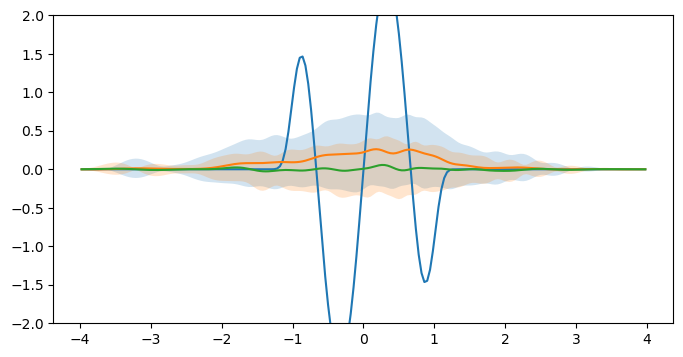

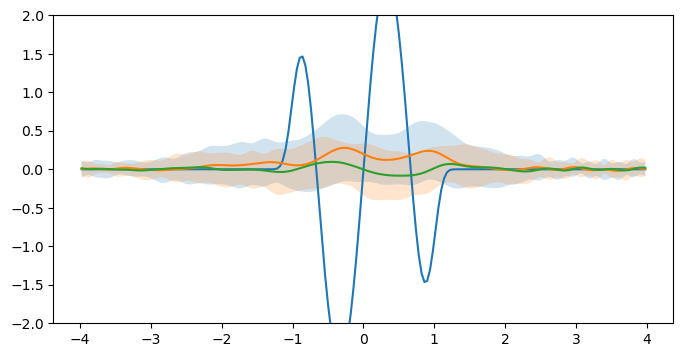

In [99]:
plt.figure(figsize=(8, 4))
plt.ylim(-2,2)
ex.plot(plt, x, V/4)
ex.plotshaded(plt, x, real(u0))
ex.plotshaded(plt, x, imag(u0))
plt.show()


plt.figure(figsize=(8, 4))
plt.ylim(-2,2)
ex.plot(plt, x, V/4)
ex.plotshaded(plt, x, real(uT))
ex.plotshaded(plt, x, imag(uT))
plt.show()

# Neural Network Model

In [100]:
class VNN(nn.Module):

    def __init__(self, x, T, N, solver):
        super(VNN, self).__init__()
        self.T = T
        self.N = N
        self.solver = solver
        
        self.n = x.shape[1]
        self.x = x.flatten().unsqueeze(1)

        self.NN = nn.Sequential(
            nn.Linear(1, 20),   # Fully connected layer 1 with 1 input and 32 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 1)    # Fully connected layer 3 with 16 input neurons and 1 output neuron
            )

        self.NN = self.NN.double().to(device)    # double precision

    def _potential(self):
        return self.NN(self.x).reshape([1, self.n])

    # for non-training needs
    def potential(self):
        with torch.no_grad():
            pot = self._potential().cpu()
        return pot

    def forward(self, u0):
        uT = self.solver(self._potential(), u0, self.T, self.N)
        return uT

        
model = VNN(x, T=0.1, N=20, solver=strangsolver)

Checking out the current potential inside the VNN

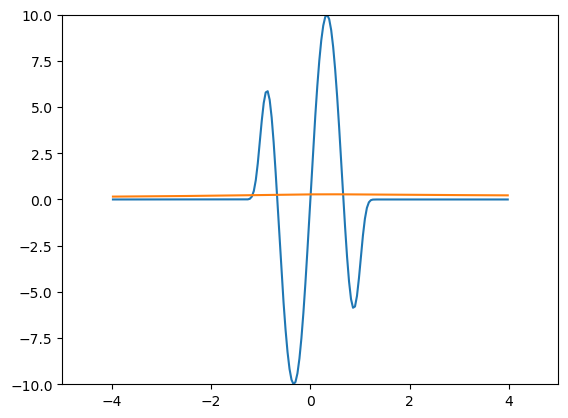

In [101]:
ex.plot(plt, x, V)
ex.plot(plt, x, model.potential())
plt.xlim(-5,5)
plt.ylim(-10,10)

plt.show()

Solving till T under the current potential of the VNN

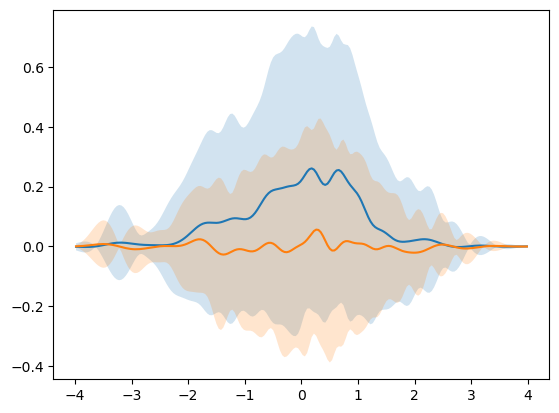

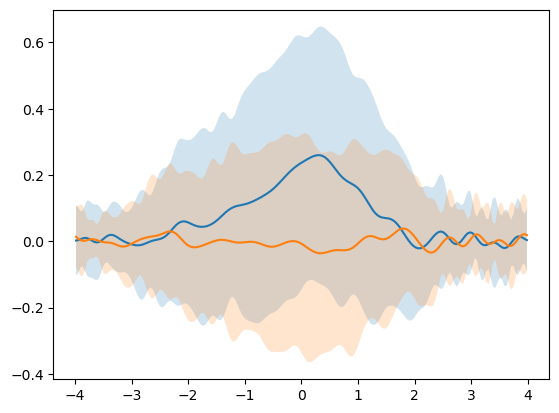

In [102]:
uTmod = model(u0)

ex.plotshaded(plt, x, real(u0))
ex.plotshaded(plt, x, imag(u0))
plt.show()
plt.figure()
ex.plotshaded(plt, x, real(uTmod))
ex.plotshaded(plt, x, imag(uTmod))
plt.show()

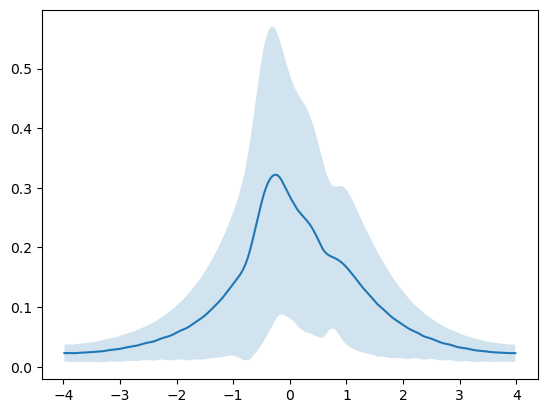

In [103]:
ex.plotshaded(plt, x, abs(strangsolver(V, u0, 0.2, 20)-strangsolver(0*V, u0, 0.2, 20)) )    # what happens when we get V incorrect
plt.show()

### Loss function

Batch loss

In [104]:
u0, uTref = next(dataiterator)
uTmod = model(u0)

dx = x[0,1]-x[0,0]
criterion = nn.MSELoss()
loss = n * dx * (criterion(real(uTmod), real(uTref)) + criterion(imag(uTmod), imag(uTref)))
loss

tensor(0.1063, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)

Looped loss function

In [106]:
def looplossfn(V, u0batch, uTbatch, solver, T, N):
    dx = x[0,1]-x[0,0]
    nbatch = u0batch.shape[0]

    loss = torch.tensor(0., dtype=torch.float64).to(device)

    for u0, uTref in zip(u0batch, uTbatch):
        uT = solver(V, u0, T, N)
        loss += torch.norm(uT - uTref)**2
    
    loss = dx * loss/nbatch
    return loss

looplossfn(model._potential(), u0, uTref, solver=strangsolver, T=0.1, N=20)

tensor(0.1063, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

### Comparison between Batch and Looped loss

In [107]:
tim1 = time.time()
loss1 = n * dx * (criterion(real(uTmod), real(uTref)) + criterion(imag(uTmod), imag(uTref)))
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {batch_size} took {tim_batch}s')
print(f'Batch Loss: {loss1}')

tim1 = time.time()
loss2 = looplossfn(model._potential(), u0, uTref, solver=strangsolver, T=0.1, N=20)
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {batch_size} took {tim_loop}s')
print(f'Loop Loss: {loss2}')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

print(f'Difference in losses: {torch.abs(loss2-loss1)}')

Batch of size 100 took 0.0010025501251220703s
Batch Loss: 0.10631523570767738
Loop of size 100 took 3.3068253993988037s
Loop Loss: 0.10631523570767737
Speed up factor 3298.41 on cuda
Difference in losses: 1.3877787807814457e-17


In [116]:
%matplotlib inline

# Create an instance of the SimpleNN model
model = VNN(x, T=0.1, N=20, solver=strangsolver).to(device)
nn.DataParallel(model).to(device)

nbatch = 50
dataloader = DataLoader(dataset, batch_size=nbatch, shuffle=True)
dataiterator = iter(dataloader)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, dtype=torch.double)
num_steps = 1000

trerror = []


dx = x[0,1]-x[0,0]
criterion = nn.MSELoss()


for step in range(num_steps):
    # Compute the loss
    u0, uTref = next(dataiterator)
    uTmod = model(u0)
    
    tim1 = time.time()
    loss = n * dx * (criterion(real(uTmod), real(uTref)) + criterion(imag(uTmod), imag(uTref)))
    tim2 = time.time()
    tim_batch = tim2-tim1
    #print(f'Loss {loss} computed with batch of size {nbatch} in {tim_batch:e}s')

    optimizer.zero_grad()

    # Compute gradients
    tim1 = time.time()
    loss.backward()
    tim2 = time.time()
    tim_backward = tim2-tim1
    #print(f'Backprop computed in {tim_backward:e}s')


    if np.mod(step, 10)==0:
        trerror.append(loss.detach().cpu().numpy())        
        plt.semilogy(trerror)
        display.display(plt.gcf())
        display.clear_output(wait=True)

    # Update parameters using the gradients
    tim1 = time.time()
    optimizer.step()
    tim2 = time.time()
    tim_opt = tim2-tim1
    #print(f'Optimizer step taken in {tim_opt:e}s')


print(f'At step {step}, loss is {loss}')

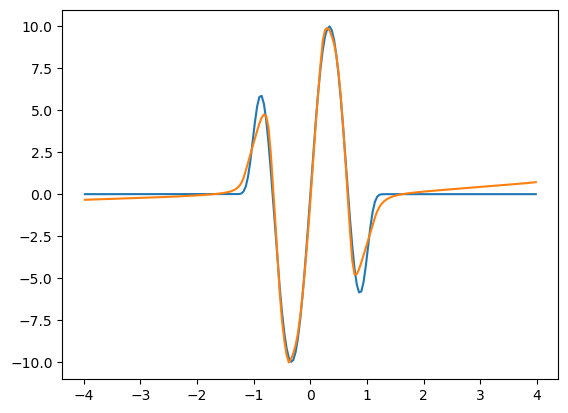

In [115]:
ex.plot(plt, x, V)
ex.plot(plt, x, model.potential())
plt.show()

The following comment pertains to batch size of 10 and 300 iterations.

One should note that we are using a very small N=20 here, and a very simple splitting: Strang. There is a huge difference between using Strang and BlanesMoan.

Decreasing to N=10 does not decrease time by more than 10%.

Increasing to N=100 makes time < 2x. Not 5x. 

Moving to BlanesMoan with N=20 increases time by 5x. 


# Optimal Control